In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.3/78.2 GB disk)


`detect.py` runs YOLOv5 on a variety of sources, it will download model from its repository automatically. it saves results to `runs/detect` after running command. For example:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image 
                          vid.mp4  # video
                          screen  # screenshot
                          path/  # directory
                         'path/*.jpg'  # glob
                         'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                         'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

We will run `detect.py` with the weights provided by YOLOv5 and set the image width to be 700 for all images present in `data/images`. The object recognition will onpy happen if the confidence is `>= 0.25`

In [ ]:
!python detect.py --weights yolov5s.pt --img 320 --conf 0.25 --source data/images

detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-177-g89c3040 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

100% 14.1M/14.1M [00:00<00:00, 60.6MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /content/yolov5/yolov5/data/images/bus.jpg: 320x256 3 persons, 1 bus, 79.2ms
image 2/2 /content/yolov5/yolov5/data/images/zidane.jpg: 192x320 2 persons, 1 tie, 142.6ms
Speed: 3.5ms pre-process, 110.9ms inference, 242.7ms NMS per image at shape (1, 3, 320, 320)
Results saved to runs/detect/exp


We can now display the images. These images are saved in `runs/detect/exp`. The `exp` is incremented depending on the number of experiments we run on the images.

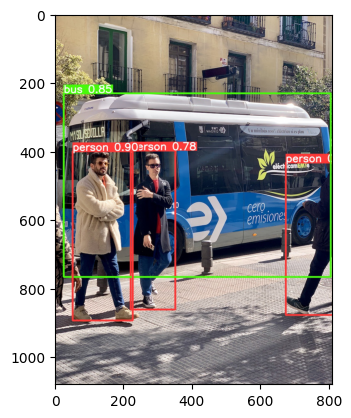

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Let's display one of the images called `bus.jpg`
image = mpimg.imread('runs/detect/exp/bus.jpg')
imgplot = plt.imshow(image)
plt.show()

Let's run a flask server with ngrok. Ngrok will direct colab's traffic to the outside world to host a web app. Through that web app we will use our camera to detect objects by feeding the model raw images.

To do this, we will use subprocesses to start a process for YOLOv5. We will use source 0 for our camera

In [ ]:
!pip install pyngrok
!ngrok config add-authtoken 2PvXGxYB4gB3Y7oK3crQmovqeQD_TXj6TMYoNWyPHyzGLkDd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=19f4cb3d439da759d24ced0babd777f9b6bb429c3bb52e21222ea4f38eda5047
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from flask import Flask, render_template, Response, url_for, request
from pyngrok import ngrok
import cv2
import subprocess
import os
import numpy as np

import time

app = Flask(__name__)
PORT = 5000
# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(PORT).public_url
print(f" * ngrok tunnel {public_url} -> http://127.0.0.1:{PORT}")

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

def get_sorted_directory():
  # Read image output by YOLOv5 by getting
    exp_directories = [
        dir for dir in os.listdir("runs/detect/") 
          if os.path.isdir(f"runs/detect/{dir}")
      ]
    sorted_dir = sorted(exp_directories, key=lambda dir: os.path.getmtime(os.path.join("runs/detect/", dir)))
    image = cv2.imread(
        f"runs/detect/{sorted_dir[-1]}/frame.jpg"
    )

    return sorted_dir[-1]

def generate_frames():
    print("Capturing photo...")
    file_name = take_photo()
    print("Photo captured.")

    image = cv2.imread(file_name)

    print("Writing to disk...")
    cv2.imwrite("data/frame.jpg", image)
    print("Photo written to disk")
    
    # YOLOv5 process
    print("Processing with YOLOv5...")
    yolov5_process = subprocess.run(
      ['python', 'detect.py', '--weights', 'yolov5s.pt', '--conf', '0.25', '--source', 'data/frame.jpg']
    )
    print("Processing done", yolov5_process.returncode)

    dir = get_sorted_directory()
    image = cv2.imread(
        f"runs/detect/{dir}/frame.jpg"
    )
    # Convert to bytes to send to web app
    buffer = cv2.imencode('.jpg', image)[1]
    frame = buffer.tobytes()

    print("Sending to app...")
    return frame

@app.route('/upload', methods=['POST'])
def upload():
    file_bytes = request.data
    print("Received data")

    print("Converting to numpy array from bytes...")
    np_bytes_array = np.frombuffer(file_bytes, dtype=np.uint8)
    image = cv2.imdecode(np_bytes_array, flags=1)
    print("Converted")

    cv2.imwrite("data/frame.jpg", image)
    print("Write to disk successful")
    
    print("Processing with YOLOv5...")
    yolov5_process = subprocess.run(
      ['python', 'detect.py', '--weights', 'yolov5s.pt', '--conf', '0.25', '--source', 'data/frame.jpg']
    )
    print("Processing done", yolov5_process.returncode)

    dir = get_sorted_directory()
    image = cv2.imread(
        f"runs/detect/{dir}/frame.jpg"
    )
    # Convert to bytes to send to web app
    buffer = cv2.imencode('.jpg', image)[1]
    frame = buffer.tobytes()

    print("Sending to app...")
    return Response(frame, mimetype='image/jpeg')

@app.route('/')
def index():
    return f'''
      <!DOCTYPE html>
      <html>
      <head>
          <title>Object Detection with YOLOv5</title>
      </head>
      <script>
          function init(event) {{
              fetch("/video_feed")
                  .then(response => response.blob())
                  .then(blob => {{
                      const reader = new FileReader();
                      reader.onloadend = function() {{
                          const base64data = reader.result;
                          const imageElement = document.getElementById('video-feed');
                          imageElement.src = base64data;
                      }};
                      reader.readAsDataURL(blob);
                  }});
          }}

          function uploadImage(event) {{
              const uploadElement = document.getElementById("upload-files");

              console.log(uploadElement.files);
              if (uploadElement.files.length == 0)
                  return;
              
              const file = uploadElement.files[0];

              const reader = new FileReader();
              reader.onloadend = function() {{
                  const fileData = new Uint8Array(reader.result);

                  fetch('/upload', {{
                          method: "POST",
                          body: fileData
                      }},
                  )
                  .then(response => response.blob())
                  .then(blob => {{
                      const reader = new FileReader();
                      reader.onloadend = function() {{
                          const base64data = reader.result;
                          const imageElement = document.getElementById('video-feed');
                          imageElement.src = base64data;
                      }};
                      reader.readAsDataURL(blob);
                  }});
              }}
              reader.readAsArrayBuffer(file);
          }}
      </script>
      <style>
          * {{
              font-family: Arial, Helvetica, sans-serif;
          }}

          body {{
              background: rgb(238,174,202);
              background: radial-gradient(circle, rgba(238,174,202,1) 0%, rgba(161,148,233,1) 100%);
              margin:0%;
          }}

          .nav {{
              display: flex;
              align-items: center;
              justify-content: space-between;
              padding: 10px;
              background: rgb(238,174,202);
              background: radial-gradient(circle, rgba(238,174,202,1) 0%, rgba(161,148,233,1) 100%);
          }}

          .ul {{
              display: flex;
              list-style-type: none;
              margin-right: 40px;
              gap: 50px;
              color: white;
          }}

          li {{
              display: inline;
              color: white;
          }}

          a {{
              color: azure;
              font-family: 'Times New Roman', Times, serif;
              font-size: larger;
          }}

          .object {{
              color: azure;
              font-family: 'Times New Roman', Times, serif;
              font-size: larger;
          }}

          .gibberish {{
              color: azure;
              font-family: 'Times New Roman', Times, serif;
              font-size: larger;
              text-align: center;
          }}

          .button {{
              outline: none;
              border: 0;
              font-weight: bold;
              background: #A796E6;
              cursor: pointer;
              color: white;
              border-radius: 0.5em;
              padding: 0.75em 1em;
              transition: background 500ms ease-in-out;
          }}

          .button:hover {{
              background: hsl(330, 80, 45);
          }}

          .container {{
              display: flex;
              flex-direction: column;
              justify-content: center;
              align-items: center;
          }}

          #video-feed {{
              margin-top: 1rem;
              border-radius: 15px;
              object-fit: cover;
              width: 500px;
          }}
      </style>
      <body>
          <nav class="nav">
              <p class="object">Object Detection</p>
              <ul class="ul">
                  <a href="{url_for('problem')}">The Problem</a>
                  <a href="{url_for('about')}">About YoloV5</a>
              </ul>
          </nav>

          <div class="container">
              <h1 class="gibberish"> Witness The Power Of YOLOV5!</h1>
              <div>
                  <button class="button" id="captureButton">Capture Photo</button>
                  <input class="button" type="file" id="upload-files" onchange='uploadImage()'>
              </div>
              <img id="video-feed" src="">
              <video id="video" autoplay></video>
          </div>
          <script>
            const videoElement = document.getElementById('video');
            const captureButton = document.getElementById('captureButton');

            captureButton.addEventListener('click', () => {{
              const canvas = document.createElement('canvas');
              canvas.width = videoElement.videoWidth;
              canvas.height = videoElement.videoHeight;

              const context = canvas.getContext('2d');
              context.drawImage(videoElement, 0, 0, canvas.width, canvas.height);

              const imageDataURL = canvas.toBlob((blob) => {{
                sendPhoto(blob);
              }}, 'image/jpeg'); // Convert canvas to base64 image data
            }});

            navigator.mediaDevices.getUserMedia({{ video: true }})
              .then((stream) => {{
                videoElement.srcObject = stream;
              }})
              .catch((error) => {{
                console.error('Error accessing webcam:', error);
              }});

            function sendPhoto(imageData) {{
              const reader = new FileReader();
                reader.onloadend = function() {{
                    const fileData = new Uint8Array(reader.result);

                    fetch('/upload', {{
                            method: "POST",
                            body: fileData
                        }},
                    )
                    .then(response => response.blob())
                    .then(blob => {{
                        const reader = new FileReader();
                        reader.onloadend = function() {{
                            const base64data = reader.result;
                            const imageElement = document.getElementById('video-feed');
                            imageElement.src = base64data;
                        }};
                        reader.readAsDataURL(blob);
                    }});
                }}
                reader.readAsArrayBuffer(imageData);
            }}
        </script>
      </body>
      </html>
      '''


@app.route('/video_feed')
def video_feed():
    return Response(generate_frames(), mimetype='image/jpeg')


@app.route('/problem')
def problem():
    return '''
      <style>
          body {
              background: rgb(238,174,202);
              background: radial-gradient(circle, rgba(238,174,202,1) 0%, rgba(161,148,233,1) 100%);
              margin:0%;
          }

          .nav {
              display: flex;
              align-items: center;
              justify-content: space-between;
              padding: 10px;
              background: rgb(238,174,202);
              background: radial-gradient(circle, rgba(238,174,202,1) 0%, rgba(161,148,233,1) 100%);
          }

          .ul {
              display: flex;
              list-style-type: none;
              margin-right: 40px;
              gap: 50px;
          }

          li {
              display: inline;
              color: white;
          }

          a {
              color: azure;
              font-family: 'Times New Roman', Times, serif;
              font-size: larger;
          }

          .object {
              color: azure;
              font-family: 'Times New Roman', Times, serif;
              font-size: larger;
          }

          .gibberish {
              color: azure;
              font-family: 'Times New Roman', Times, serif;
              font-size: larger;
              text-align: center;
          }

          .container {
              display: flex;
              flex-direction: column;
              justify-content: center;
              align-items: center;
          }
      </style>

      <body>
          <nav class="nav">
              <p class="object">Object Detection</p>
              <ul class="ul">
                  <a href="#ContactUs">The Problem</a>
                  <a href="#AboutUs">About YoloV5</a>
              </ul>
          </nav>

          <div class="container">
              <h1 class="gibberish"> The Problem</h1>
              <p class="gibberish">One of the biggest difficulties of object detection is that an object viewed from different angles may look completely different. 
                  Thus, the goal of detectors is to recognize objects from different viewpoints.
                  The subject of computer vision analysis is not only a solid object but also bodies that can be deformed and change their shapes, 
                  which provides additional complexity for object detection. Sometimes objects can be obscured by other things, which makes it difficult to read the signs and identify these objects. 
                  Lighting has a very large influence on the definition of objects. The same objects will look different depending on the lighting conditions. The less illuminated space, the less visible the objects are. All of these factors affect the detector’s ability to define objects.Objects that need to be identified may blend into the background, making it difficult to identify them. 
                In such cases, the object detector will encounter detection problems.The same object can have completely different shapes and sizes. Computer vision needs to do a lot of research to read an object and understand what it means.
                  When it comes to video, detectors need to be trained to perform analysis in an ever-changing environment. It means that object detection algorithms must not only accurately classify important objects but also be incredibly fast during prediction to be able to identify objects that are in motion.</p>
          </div>
      </body>
      '''


@app.route('/about')
def about():
    return '''
      <style>
          body {
              background: rgb(238,174,202);
              background: radial-gradient(circle, rgba(238,174,202,1) 0%, rgba(161,148,233,1) 100%);
              margin:0%;
          }

          .nav {
              display: flex;
              align-items: center;
              justify-content: space-between;
              padding: 10px;
              background: rgb(238,174,202);
              background: radial-gradient(circle, rgba(238,174,202,1) 0%, rgba(161,148,233,1) 100%);
          }

          .ul {
              display: flex;
              list-style-type: none;
              margin-right: 40px;
              gap: 50px;
          }

          li {
              display: inline;
              color: white;
          }

          a {
              color: azure;
              font-family: 'Times New Roman', Times, serif;
              font-size: larger;
          }

          .object {
              color: azure;
              font-family: 'Times New Roman', Times, serif;
              font-size: larger;
          }

          .gibberish {
              color: azure;
              font-family: 'Times New Roman', Times, serif;
              font-size: larger;
              text-align: center;
          }

          .container {
              display: flex;
              flex-direction: column;
              justify-content: center;
              align-items: center;
          }
      </style>

      <body>
          <nav class="nav">
              <p class="object">Object Detection</p>
              <ul class="ul">
                  <a href="#ContactUs">The Problem</a>
                  <a href="#AboutUs">About YoloV5</a>
              </ul>
          </nav>

          <div class="container">
              <h1 class="gibberish"> About YOLOv5</h1>
              <p class="gibberish">The YOLOv5 repository is a natural extension of the YOLOv3 PyTorch repository by Glenn Jocher. The YOLOv3 PyTorch repository was a popular destination for developers to port YOLOv3 Darknet weights to PyTorch and then move forward to production. Many liked the ease of use the PyTorch branch and would use this outlet for deployment.

                  After fully replicating the model architecture and training procedure of YOLOv3, Ultralytics began to make research improvements alongside repository design changes with the goal of empowering thousands of developers to train and deploy their own custom object detectors to detect any object in the world. </p>

              <p class="gibberish"> Object detection, a use case for which YOLOv5 is designed, involves creating features from input images. These features are then fed through a prediction system to draw boxes around objects and predict their classes. The YOLO model was the first object detector to connect the procedure of predicting bounding boxes with class labels in an end to end manner. This way a full pipeline could be trained jointly.
                  The YOLO family of models owes a great deal of its inspiration to the advancements made in the field of object detection.
                  From its inception, one of YOLO's main goals has been to develop a complete object detection system that could be applied to any object detection task while still being useful for real time systems.  
                  Object detection is the process of locating and classifying objects in images and video. Since the inception of computer vision, there has been a need for algorithms to locate and classify these objects. An object can be a person, car, animal, or anything else. Object detection has many applications, including video surveillance, self-driving cars, and augmented reality. 
                  The YOLOv5 repository aims to provide a simple, intuitive, and highly efficient object detection system that can be used by researchers, developers, and practitioners alike. </p>
          </div>
      </body>
      '''

# Start the Flask server
app.run()

In [ ]:
!rm -rf runs/detect